In [2]:
#import libraries:
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib.image import imread 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from PIL import Image
from skimage import io
from numpy import *
import plotnine as p9
from tensorflow.linalg import eigh

C:\Users\Wyatt\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!


In [3]:
#read in image CSV file:
imgs = pd.read_csv("C:/Users/Workman/Documents/STA142A_W22/vehcle_img_data.csv")
imgs.head()


C:\Users\Wyatt\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


,Image_Path,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity
0,vehicle_images/1633889154186_Toyota Hilux 2006...,Toyota,Hilux,Hilux,2006,Used,Manual,SUV / 4x4,Diesel,"2,500 cc"
1,vehicle_images/1633889154395_Land Rover Freela...,Land Rover,Freelander,1999,1999,Used,Manual,SUV / 4x4,Diesel,"1,990 cc"
2,vehicle_images/1633889154545_Nissan Leaf G Gra...,Nissan,Leaf,G Grade,2014,Used,Automatic,Hatchback,Electric,70 cc
3,vehicle_images/1633889154697_Mercedes Benz C20...,Mercedes Benz,C200,C-Cabriolet AMG Line,2016,Used,Automatic,Convertible,Petrol,"2,000 cc"
4,vehicle_images/1633889154870_Toyota Vitz 2018 ...,Toyota,Vitz,2018,2018,Used,Automatic,Hatchback,Petrol,"1,000 cc"


For the scope of this project, we will only consider 5 different classes.

In [4]:
#encode the response variable:
#ensure response column is of categorical datatype:
imgs["Body"] = imgs["Body"].astype("category").cat.codes

#assign numerical labels:
#imgs["Body"] = imgs["Body"].cat.codes
#imgs = imgs[imgs["Body"] <= 5]
imgs.head()

,Image_Path,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity
0,vehicle_images/1633889154186_Toyota Hilux 2006...,Toyota,Hilux,Hilux,2006,Used,Manual,14,Diesel,"2,500 cc"
1,vehicle_images/1633889154395_Land Rover Freela...,Land Rover,Freelander,1999,1999,Used,Manual,14,Diesel,"1,990 cc"
2,vehicle_images/1633889154545_Nissan Leaf G Gra...,Nissan,Leaf,G Grade,2014,Used,Automatic,6,Electric,70 cc
3,vehicle_images/1633889154697_Mercedes Benz C20...,Mercedes Benz,C200,C-Cabriolet AMG Line,2016,Used,Automatic,4,Petrol,"2,000 cc"
4,vehicle_images/1633889154870_Toyota Vitz 2018 ...,Toyota,Vitz,2018,2018,Used,Automatic,6,Petrol,"1,000 cc"


In [5]:
imgs["Body"].value_counts()

 3     21984
 10    15723
 20     5595
 6      5502
 17     5099
 15     4787
 8      4248
 13     3583
 14     3282
 12     1492
-1      1224
 19     1076
 1      1070
 18      779
 0       617
 16      584
 21      513
 7       351
 2       158
 9       149
 5       111
 4        50
 11        3
Name: Body, dtype: int64

To avoid class imbalance and skewness, we will pick classes with similar number of images belonging to them.

In [6]:
imgs = imgs[imgs["Body"].isin([20,6,17,15,8])]
imgs.head()

,Image_Path,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity
2,vehicle_images/1633889154545_Nissan Leaf G Gra...,Nissan,Leaf,G Grade,2014,Used,Automatic,6,Electric,70 cc
4,vehicle_images/1633889154870_Toyota Vitz 2018 ...,Toyota,Vitz,2018,2018,Used,Automatic,6,Petrol,"1,000 cc"
5,vehicle_images/1633889155051_Toyota Starlet EP...,Toyota,Starlet,EP71,1990,Used,Manual,6,Petrol,"1,300 cc"
6,vehicle_images/1633889155191_Toyota Aqua S 201...,Toyota,Aqua,S,2014,Used,Automatic,6,Hybrid,"1,500 cc"
8,vehicle_images/1633889155496_Toyota Axio editi...,Toyota,Axio,edition,2015,Used,Automatic,15,Petrol,"1,500 cc"


In [7]:
#create response vector:
response = imgs["Body"].to_numpy()

In [8]:
len(imgs)

25231

In [9]:
len(response)

25231

In [10]:
#extract rows where image_path is not blank:
#replace blanks in image path col with NA:
imgs["Image_Path"].replace('', np.nan, inplace=True)

#keep rows without NA in the image path column:
imgs = imgs[imgs["Image_Path"].notna()]
print(len(imgs))

25231


In [11]:
#load an image:
print(imgs.iat[10200,0])
string = "C:/Users/Workman/Documents/STA142A_W22/vehicle_images/" + imgs.iat[10199,0]
img = rgb2gray(Image.open(string))

vehicle_images/1635928138821_Toyota Vitz KSP90 2007 for sale.jpg


(107, 142)


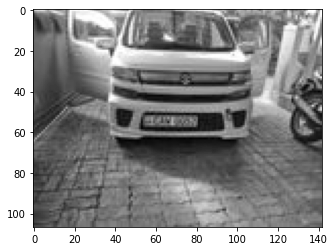

In [12]:
plt.imshow(img, cmap = "gray" )
print(np.shape(img))

(75, 100)
[[0.71718667]
 [0.80401176]
 [0.81157216]
 ...
 [0.41476275]
 [0.39123333]
 [0.37498157]]


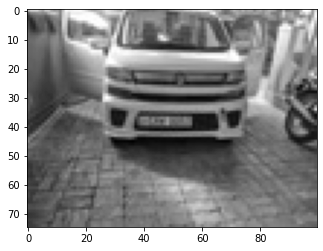

In [13]:
img2 = rgb2gray(Image.open(string).resize((100,75)))
plt.imshow(img2, cmap = "gray")
print(np.shape(img2))
print(np.asarray(img2).reshape(7500,1))

In [14]:
#create function to resize images to smallest dimension in dataset:
def img_resize(img_df, img_loc, dims = (100,75), path = "C:/Users/Workman/Documents/STA142A_W22/vehicle_images/"):
    #create image path and open image:
    string = str(path) + img_df.iat[img_loc[0], img_loc[1]]
    try:
        img = rgb2gray(Image.open(string).resize(dims))
        #convert image to numpy vector:
        img_vec = np.asarray(img).reshape(7500,1)
        return img_vec
    except:
        pass

    

In [15]:
#resize images so that they are the same size:
img_vec = [(img_resize(imgs, (i,0))) for i in range(0,len(imgs))]

In [16]:
#verify that this vector corresponds to the one printed earlier:
(img_vec[10199])

array([[0.71718667],
       [0.80401176],
       [0.81157216],
       ...,
       [0.41476275],
       [0.39123333],
       [0.37498157]])

In [17]:
#extract arrays from list of arrays:
imgs_concat = [img_vec[i] for i in range(0,len(img_vec))]

In [18]:
#concatenate all image vectors into one matrix:
img_array = np.stack(imgs_concat, axis = 0)

In [19]:
#get dims of data matrix:
np.shape(img_array)

(25231, 7500, 1)

In [20]:
#convert from 3d array to 2d array:
img_array = img_array.reshape(25231,(7500*1))

In [21]:
#verify matrix dims:
print(np.shape(img_array))


(25231, 7500)


In [22]:
#change datatype to reduce stroage space:
img_array = img_array.astype("float32")

In [23]:
#Turn array into npz file:
savez_compressed("img_array.npz", img_array)


In [3]:
#load in data matrix:
dat = np.load("C:/Users/Workman/Documents/STA142A_W22/img_array.npz")

#extract data matrix from npz file:
dat = dat["arr_0"].T

In [4]:
print(np.shape(dat))
#convert datatype to float32:
dat = dat.astype("float32")

(7500, 25231)


# Part 1: PCA:

First, we compute the principal component vectors for our dataset, and determine how many to use.

In [16]:
#create eig function to speed up the decomposition?
def eig(A,k):
    val,vec = sp.sparse.linalg.eigsh(A,k)
    return val,vec

In [5]:
#check if dat is symmetric:
np.all(dat) == np.all(dat.T)

True

In [5]:
#subtract column means from respective columns:
dat_mean = dat - np.mean(dat, axis = 0)
dat_mean = dat_mean
print(1)
#calculate covariance matrix of meaned data:
cov_mat = np.cov(dat_mean, rowvar = False)
print(np.shape(cov_mat))


1
(25231, 25231)


In [26]:
#compute eigenvalues and eigenvectors of covariance matrix:
evals, evecs = sp.sparse.linalg.eigsh(cov_mat, k = 3000, tol = 1e-5)
print(3)
#order the eigenvalues/vectors in descending order:
index = np.argsort(evals)[::-1]
print(4)
evals_sort = evals[index]
print(5)
evecs_sort = evecs[:,index]

3
4
5


Next, we determine the optimal amount of principal components to use for the data. We will do this by calculating the percentage of variance in the data that is explained by each principal component, by using the following formula:

$$\frac{\lambda_i}{\lambda_1 + \lambda_2 + ... + \lambda_n}$$

In [27]:
#calculate variation accounted for by each principal component:
var_func = lambda x: x/np.sum(evals_sort)
var_explained = [var_func(evals_sort) for i in evals_sort]


In [28]:
print(np.shape(var_explained))

(3000, 3000)


In [29]:
var_explained = np.cumsum(var_explained[0])
print(np.shape(var_explained))

(3000,)


In [30]:
plot_df = pd.DataFrame(data = {
    "var":np.real(var_explained),
    "num_components": list(range(1,len(var_explained)+1))
})

plot_df.head()

,var,num_components
0,0.105037,1
1,0.201275,2
2,0.258381,3
3,0.308181,4
4,0.347380,5


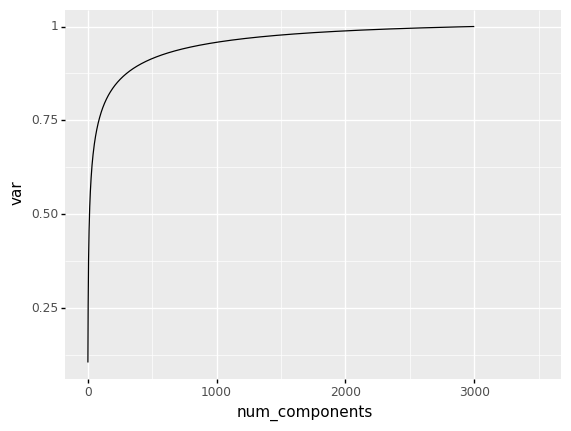

<ggplot: (94704524087)>

In [32]:
#create plot:
var_plot = p9.ggplot(data = plot_df)
var_plot += p9.aes(x = "num_components", y = "var")
var_plot += p9.geom_line()
var_plot += p9.xlim(0,3500)

var_plot